In [1]:
from __future__ import division
import pylab as plt
from numpy import random,argwhere,linspace
from numpy.random import randint
import numpy as np
%matplotlib inline

In [2]:
tmax = 120
dt = 1
nt = int(1 + tmax/dt)

velocities = [-1.0, 0.0, 1.0]
klevels = np.linspace(0,0.98,12)
pp = np.array([0.20,0.35,0.45])

def get_P(k):
    # parameter k tunes the hysteresis
    # parameter pp are the columns of P when k=0
    P0 = np.tile(pp,(3,1)).T # matrix when k=0
    P1 = np.eye(3)           # matrix when k=1
    return P0*(1-k)+P1*k 

def update(x,s,P,dt):
    # Draw a new state
    s.append(random.choice(range(3),p=P[:,s[-1]]))
    # Determine new velocity
    v = velocities[s[-1]]
    # Append new position
    x.append(x[-1]+v*dt)

In [3]:
def markov_sim(k,n=1,plots=False):
    """
    k = parameter tuning the hysteresis
    n = number of simulations to run (only last sim is returned)
    """
    P = get_P(k) # state transition matrix
    
    for i in range(n):
        x = [0]          # initial position
        s = [random.choice(range(3),p=pp)] # initial state
        t = 0            # initial time
        while t < tmax:
            t += dt
            update(x,s,P,dt)
        if plots: plt.plot(linspace(0,tmax,len(x)),x)
    
    if plots:
        plt.yticks([-4,6])
        plt.xlabel('time',fontsize=15)
        plt.ylabel('position',fontsize=15)
    return x,s

In [4]:
# plt.figure(figsize=(12,3))
# for splt,k in enumerate(klevels):
#     plt.subplot(1,3,splt+1)
#     markov_sim(k,n=3,plots=False)
#     plt.title('k = '+str(k),fontweight='bold',fontsize=15)
# plt.tight_layout()
# plt.savefig('panelA.svg')
# plt.show()

In [5]:
def sim_ensemble(k,N):
    """ N = number of molecules to simulate """
    X = []
    for i in range(N):
        x,s = markov_sim(k,n=1)
        X.append(x)

    X = np.array(X).T        # each column of X is a trajectory
    t = linspace(0,tmax,len(x))  # time axis
    return t,X

def bin_cable(X,nbins):
    d0,d1 = -120.5,120.5          # ends of the cable
    Bx = np.linspace(d0,d1,nbins) # compartment edges
    dx = Bx[1]-Bx[0]              # compartment size
    Bxc = Bx[:-1]+(dx/2)          # compartment centers
    Cx = np.empty((nt,len(Bxc)))  # concentration in each compartment

    for i in range(len(Bxc)):
        Cx[:,i] = np.mean((X > Bx[i]) & (X <= Bx[i+1]),axis=1)
    
    return Cx,Bxc

def plot_conc_profile(data):
    """ Plot the spatial distribution at several time points"""
    tp = np.round(np.linspace(5,tmax,7))#range(10,nt,30)
    cols = np.vstack((np.linspace(0,1,len(tp)),np.zeros(len(tp)),np.linspace(1,0,len(tp))))
    for (c,i) in enumerate(tp):
        plt.plot(Bxc,data[i,:],'-',color=cols[:,c],lw=2)
    plt.yticks([0,0.2])
    plt.ylim([0,0.22])
    plt.xlim([-25,75])
    plt.xlabel('position',fontsize=15)
    plt.ylabel('concentration',fontsize=15)

In [6]:
Cx_store = []

#plt.figure(figsize=(12,3))
for splt,k in enumerate(klevels):
    #plt.subplot(1,3,splt+1)
    t,X = sim_ensemble(k,500)
    Cx,Bxc = bin_cable(X,int(tmax)*2+1)
    Cx_store.append(Cx)
    #plot_conc_profile(Cx)
    #plt.title('k = '+str(k),fontweight='bold',fontsize=15)
# plt.tight_layout()
# plt.savefig('panelB.svg')
# plt.show()

In [7]:
from scipy.linalg import expm

def mass_action_matrix(a_,b_,nC):
    # transport rate constants
    a = np.ones(nC-1)*a_
    b = np.ones(nC-1)*b_

    # construct state-transistion matrix, A
    mid = np.zeros(nC)
    mid[:-1] -= a
    mid[1:]  -= b
    return np.diag(a, -1) + np.diag(mid) + np.diag(b, 1)

def mass_action_simulate(A,nC):
    # initial condition
    u0 = np.zeros(nC)
    u0[(nC-1)/2] = 1.0
    
    # simulate
    u = [u0]   # concentration in each compartment
    eA = expm(A*dt)
    for i in range(nt-1):
        u.append(np.dot(eA,u[-1]))
    return np.array(u)

def f(x,Ctarg,make_plot=False):
    nC = Ctarg.shape[1]
    A = mass_action_matrix(x[0],x[1],nC)
    u = mass_action_simulate(A,nC)
    
    if make_plot:
        print A
        plt.plot(t,u)
        plt.show()
    
    return np.sum((u-Ctarg)**2)

In [8]:
from scipy.optimize import minimize
CxFit_store = []
sol_store = []

#plt.figure(figsize=(12,3))
for i,Cx in enumerate(Cx_store):
    #plt.subplot(1,3,i+1)
    if klevels[i] == 0.0:
        a_opt,b_opt = pp[2],pp[0]
    else:
        sol = minimize(lambda x: f(x,Cx),[pp[2],pp[0]],bounds=[(0,None),(0,None)])
        a_opt,b_opt = sol.x
    A = mass_action_matrix(a_opt,b_opt,Cx.shape[1])
    CxFit = mass_action_simulate(A,Cx.shape[1])
    #plot_conc_profile(CxFit)
    CxFit_store.append(CxFit)
    sol_store.append([a_opt,b_opt])
    #plt.title('k = '+str(klevels[i]),fontweight='bold',fontsize=15)
#plt.tight_layout()
#plt.savefig('panelC.svg')
#plt.show()

sol_store = np.array(sol_store)

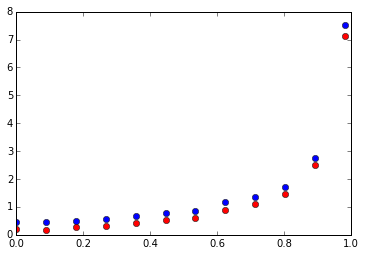

In [26]:
plt.figure()
plt.plot(klevels,sol_store[:,0],"ob")
plt.plot(klevels,sol_store[:,1],"or")
#plt.plot(klevels,-pp[2]/(klevels-1),"-b")
#plt.plot(klevels,-pp[0]/(klevels-1),"-r")
#plt.xlim([0, 0.8])
#plt.ylim([0, 4])
plt.show()

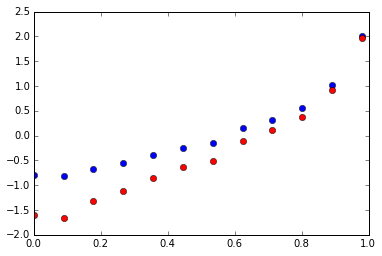

In [27]:
plt.figure()
plt.plot(klevels,np.log(sol_store[:,0]),"ob")
plt.plot(klevels,np.log(sol_store[:,1]),"or")
#plt.plot(klevels,-pp[2]/(klevels-1),"-b")
#plt.plot(klevels,-pp[0]/(klevels-1),"-r")
#plt.xlim([0, 0.8])
#plt.ylim([0, 4])
plt.show()

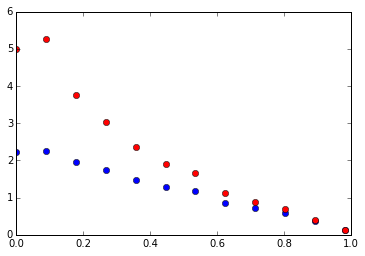

In [28]:
plt.figure()
plt.plot(klevels,1/sol_store[:,0],"ob")
plt.plot(klevels,1/sol_store[:,1],"or")
#plt.plot(klevels,-pp[2]/(klevels-1),"-b")
#plt.plot(klevels,-pp[0]/(klevels-1),"-r")
#plt.xlim([0, 0.8])
#plt.ylim([0, 4])
plt.show()